In [61]:
"""Initial analysis of shap values behavior."""
# pylint: disable=redefined-outer-name, expression-not-assigned, import-error, not-callable, pointless-statement, no-value-for-parameter, undefined-variable, unused-argument, line-too-long, use-dict-literal
from __future__ import annotations

import copy
import itertools
from collections import Counter
from pathlib import Path
from typing import Dict, List, Sequence, Set, Tuple

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import upsetplot
from IPython.display import display
from matplotlib import pyplot
from scipy.special import softmax  # type: ignore

pio.renderers.default = "notebook"

from epi_ml.core import metadata
from epi_ml.utils.bed_utils import bins_to_bed_ranges, write_to_bed

BIOMATERIAL_TYPE = "harmonized_biomaterial_type"
CELL_TYPE = "harmonized_sample_ontology_intermediate"
ASSAY = "assay_epiclass"
SEX = "harmonized_donor_sex"

In [62]:
%matplotlib inline

In [63]:
DECILES = list(np.arange(10, 100, 10) / 100)

In [64]:
def load_chroms(chrom_file):
    """Return sorted chromosome names list."""
    with open(chrom_file, "r", encoding="utf-8") as file:
        chroms = []
        for line in file:
            line = line.rstrip()
            if line:
                name, size = line.split()
                chroms.append(tuple([name, int(size)]))
    chroms.sort()
    return chroms

In [65]:
chroms = load_chroms(
    "/home/local/USHERBROOKE/rabj2301/Projects/epilap/input/chromsizes/hg38.noy.chrom.sizes"
)

In [66]:
home = Path().home() / "Projects"
input_dir = home / "epilap/input"
metadata_path = (
    input_dir
    / "metadata/dfreeze-v2/hg38_2023-epiatlas-dfreeze_v2.1_w_encode_noncore_2.json"
)
my_meta = metadata.Metadata(metadata_path)

In [67]:
output = home / "epilap/output/logs/epiatlas-dfreeze-v2.1/hg38_100kb_all_none/shap"
# logdir = (
#     output / "models/SHAP" / "harmonized_donor_sex_1l_3000n/100kb_all_none_blklst/split0/"
# )
# logdir = output / "2023-01-epiatlas-freeze/hg38_1kb_all_none/harmonized_donor_sex_1l_200n/10fold-l1-100_l2-0.01_dropout-0.50/split0/SHAP/"
# logdir = output / "2023-01-epiatlas-freeze/hg38_100kb_all_none/harmonized_donor_sex/predict-10fold-binary/lgbm-dart/lgbm-l1-0.01-l2-0.01/SHAP/split0/"
logdir = (
    output
    / "harmonized_sample_ontology_intermediate_1l_3000n/10fold/split0/shap/6hist_6ct/"
)

In [68]:
RESOLUTION = 100 * 1000

In [69]:
def select_shap_samples(shap_dict, n: int) -> Dict[str, List[np.ndarray]]:
    """Return a subset of shap values and their ids."""
    selected_shap_samples = {"shap": [], "ids": []}
    total_samples = len(shap_dict["ids"])
    selected_indices = np.random.choice(total_samples, n, replace=False)

    for class_shap_values in shap_dict["shap"]:
        selected_shap_samples["shap"].append(class_shap_values[selected_indices, :])

    selected_shap_samples["ids"] = [shap_dict["ids"][idx] for idx in selected_indices]

    return selected_shap_samples

In [70]:
def get_archives(shap_values_dir: str | Path):
    """Return shap values and explainer background archives. from npz files."""
    shap_values_dir = Path(shap_values_dir)
    try:
        shap_values_path = next(shap_values_dir.glob("*evaluation*.npz"))
        background_info_path = next(shap_values_dir.glob("*explainer_background*.npz"))
    except StopIteration as err:
        raise FileNotFoundError(
            f"Could not find shap values or explainer background archives in {shap_values_dir}"
        ) from err

    with open(shap_values_path, "rb") as f:
        shap_values_archive = np.load(f)
        shap_values_archive = dict(shap_values_archive.items())

    with open(background_info_path, "rb") as f:
        explainer_background = np.load(f)
        explainer_background = dict(explainer_background.items())

    return shap_values_archive, explainer_background

In [71]:
get_archives(logdir)[0]["classes"]

array([['0', 'T cell'],
       ['1', 'brain'],
       ['2', 'colon'],
       ['3', 'connective tissue cell'],
       ['4', 'endoderm-derived structure'],
       ['5', 'extraembryonic cell'],
       ['6', 'hepatocyte'],
       ['7', 'lymphocyte of B lineage'],
       ['8', 'macrophage'],
       ['9', 'mammary gland epithelial cell'],
       ['10', 'mesoderm-derived structure'],
       ['11', 'monocyte'],
       ['12', 'muscle organ'],
       ['13', 'myeloid cell'],
       ['14', 'neutrophil'],
       ['15', 'venous blood']], dtype='<U29')

In [72]:
def average_impact(shap_values_matrices):
    """Return average absolute shap values."""
    shap_abs = np.zeros(shap_values_matrices[0].shape)
    for matrix in shap_values_matrices:
        shap_abs += np.absolute(matrix)
    shap_abs /= len(shap_values_matrices)
    return shap_abs

In [73]:
def n_most_important_features(sample_shaps, n):
    """Return features with highest absolute shap values."""
    return np.flip(np.argsort(np.absolute(sample_shaps)))[:n]

In [74]:
def subsample_md5s(
    md5s: List[str], metadata: metadata.Metadata, category_label: str, labels: List[str]
) -> List[int]:
    """Subsample md5s based on metadata filtering provided, for a given category and filtering labels.

    Args:
            md5s (list): A list of MD5 hashes.
            metadata (Metadata): A metadata object containing the data to be filtered.
            category_label (str): The category label to be used for filtering the metadata.
            labels (list): A list of labels to be used for selecting category subsets in the metadata.

    Returns:
            list: A list of indices corresponding to the selected md5s.
    """
    meta = copy.deepcopy(metadata)
    meta.select_category_subsets(category_label, labels)
    chosen_idxs = []
    for i, md5 in enumerate(md5s):
        if md5 in meta:
            chosen_idxs.append(i)
    return chosen_idxs

In [75]:
def get_most_frequent_feature(
    pairwise_intersections: List[Set[int]], quantile_list: List[int]
) -> Dict[int, List[int]]:
    """
    Get a list of the most frequent features from multiple feature lists, according to some quantiles..

    This function takes a list of feature lists and a quantile list. It calculates the occurrence frequency
    of each feature and returns the list of features at least as frequent as the specified quantiles.

    Args:
        feature_lists (List[List[int]]): A list of feature lists, where each inner list contains feature indices.
        quantile_list (List[int]: The quantile values for which the most frequent features will be returned.

    Returns:
        Dict[int:List[int]]: A dict containing the list of features in each specified quantile.
    """
    for quantile in quantile_list:
        if quantile < 0 or quantile > 100:
            raise ValueError("Quantile values must be between 0 and 100.")

    # Compute the features in the specified quantiles
    intersection_counter = Counter()
    for feature_set in pairwise_intersections:
        intersection_counter.update(feature_set)

    df = pd.DataFrame.from_dict(data=intersection_counter, orient="index").reset_index()
    df.columns = ["Feature", "Count"]

    quantile_features_dict = {}
    for quantile in quantile_list:
        curr_q = df["Count"].quantile(
            quantile / 100
        )  # this calculates the quantile value
        curr_choice = df[
            df["Count"] >= curr_q
        ]  # this selects all features within current quantile
        quantile_features_dict[quantile] = curr_choice["Feature"].tolist()

    return quantile_features_dict


def feature_overlap_stats(
    feature_lists: List[List[int]], quantile_list: list[int]
) -> Tuple[Set[int], Set[int], Dict[int, List[int]]]:
    """
    Calculate the statistics of feature overlap between multiple feature lists.

    This function takes a list of feature lists and calculates the median and average
    pairwise overlaps between them. It also computes the union and intersection of all features
    in the given feature lists.

    Args:
        feature_lists (List[List[int]]): A list of feature lists, where each inner list contains feature indices.
        quantile_list (List[int]: The quantile values for which the most frequent features will be returned.

    Returns:
        Tuple[Set[int], Set[int], Dict[int, List]]: A tuple containing 1) intersection of all features
        2) union of all features 3) a dict containing the list of features in each specified quantile.
    """
    # Compute the overlap between two feature lists
    all_pairwise_overlaps = [
        set(sample1) & set(sample2)
        for sample1, sample2 in itertools.combinations(feature_lists, 2)
    ]
    all_pairwise_overlaps_len = [len(x) for x in all_pairwise_overlaps]
    print("Pairwise feature overlap statistics:")
    display(pd.DataFrame(all_pairwise_overlaps_len).describe())

    # Most frequent features (per quantile)
    frequent_features = get_most_frequent_feature(all_pairwise_overlaps, quantile_list)

    # Union and intersection of all features
    all_features_union: Set[int] = set()
    all_features_intersection: Set[int] = set(feature_lists[0])
    for feature_set in feature_lists:
        all_features_union.update(feature_set)
        all_features_intersection &= set(feature_set)

    return all_features_intersection, all_features_union, frequent_features  # type: ignore

In [76]:
def get_shap_matrix(
    meta: metadata.Metadata,
    shap_matrices: np.ndarray,
    eval_md5s: List[str],
    label_category: str,
    selected_labels: List[str],
    class_idx: int,
) -> Tuple[np.ndarray, List[int]]:
    """Generates a SHAP matrix corresponding to a selected subset of samples.

    This function selects a subset of samples based on specified criteria
    and then generates a SHAP matrix for these selected samples. It filters
    the metadata if a specific target subsample is provided, and selects a
    subset of samples that are identified by their md5 hash. It then selects
    the SHAP values of these samples under the matrix of the given class number.

    Args:
        meta (metadata.Metadata): Metadata object containing information about the samples.
        shap_matrices (np.ndarray): Array of SHAP matrices for each class.
        eval_md5s (List[str]): List of md5 hashes identifying the evaluation samples.
        label_category (str): Name of the category in the metadata that contains the desired labels.
        selected_labels (List[str]): Name of the classes for which samples will be considered.
        class_idx (int): Index of the class for which the shap values matrix will be used.

    Returns:
        np.ndarray: The selected SHAP matrix for the first class and for the
                    chosen samples based on the provided criteria.
        List[int]: The indices of the chosen samples in the original SHAP matrix.

    Raises:
            IndexError: If the `class_idx` is out of bounds for the `shap_matrices`.
    """
    my_meta = copy.deepcopy(meta)

    chosen_idxs = subsample_md5s(
        md5s=eval_md5s,
        metadata=my_meta,
        category_label=label_category,
        labels=selected_labels,
    )
    if len(shap_matrices.shape) == 3:  # deepSHAP
        try:
            class_shap = shap_matrices[class_idx]
        except IndexError as err:
            raise IndexError(f"Class index {class_idx} is out of bounds.") from err

        selected_class_shap = np.array(class_shap[chosen_idxs, :])
    else:  # TreeExplainer 2D
        class_shap = shap_matrices
        selected_class_shap = class_shap[chosen_idxs]
    print(
        f"Shape of selected class ({selected_labels}) shap values: {selected_class_shap.shape}"
    )
    print(f"Chose {len(chosen_idxs)} samples from {class_shap.shape[0]} samples")
    return selected_class_shap, chosen_idxs

In [77]:
def print_feature_overlap_stats(feature_stats: Sequence):
    """Prints the statistics of feature overlap.

    This function receives the feature statistics which include the intersection,
    union and frequent features in each quantile of features. It then prints
    these statistics for easy inspection.

    Args:
        feature_stats (Sequence): Tuple containing the intersection, union and
                                  frequent features in each quantile of features.
    """
    features_intersection, features_union, frequent_features = feature_stats
    print(f"Intersection of all features: {len(features_intersection)} features")
    print(f"Fully intersecting features: {list(features_intersection)}")
    print(f"Union of all features: {len(features_union)} features\n")
    for k, v in frequent_features.items():
        print(f"Most frequent features in {k}th quantile: {len(v)} features")

In [78]:
def print_importance_info(feature_selection: List[int], shap_matrix: np.ndarray):
    """Prints the feature importance information.

    This function prints the feature importance information, which includes the
    average expected contribution of the selected features and one feature (if
    the importance was uniform), and statistical descriptions of the contributions
    of the selected features.

    Args:
        feature_selection (List[int]): The indices of the selected features.
        shap_matrix (np.ndarray): The SHAP values matrix.

    """
    N = len(feature_selection)
    nb_files, nb_bins = shap_matrix.shape
    print(
        f"Average expected contribution of {N} feature if uniform importance:{N/nb_bins*100:.5f}%"
    )
    print(
        f"Average expected contribution of 1 feature if uniform importance:{1/nb_bins*100:.5f}%"
    )
    print(f"Average contribution of selected features for {nb_files} files:")
    display(
        pd.DataFrame(
            softmax(shap_matrix, axis=1)[:, list(feature_selection)].sum(axis=1) * 100
        ).describe(percentiles=DECILES)
    )
    print(f"Individual contribution of selected features for {nb_files} files:")
    display(
        pd.DataFrame(
            softmax(shap_matrix, axis=1)[:, list(feature_selection)] * 100
        ).describe(percentiles=DECILES)
    )

In [79]:
def verify_subsample_coherence(
    shap_matrices: np.ndarray, chosen_idxs: List[int], class_int: int
) -> None:
    """Verify if the subsampling is coherent with the SHAP values.

    This function calculates the mean absolute SHAP values for the samples
    identified by chosen_idxs in each class' SHAP matrix. It then checks
    if the class index for which the subsampling was done (class_int) has
    the highest mean absolute SHAP value.

    Args:
        shap_matrices (np.ndarray): Array of SHAP matrices for each class.
        chosen_idxs (List[int]): Indices of the samples chosen during subsampling.
        class_int (int): The class index for which the subsampling was performed.

    Returns:
        None: Prints out the results.
    """

    # Calculate the mean of absolute SHAP values for each class for selected samples.
    avg_abs_shap_per_class = [
        np.mean(np.abs(shap_matrices[i][chosen_idxs, :]))
        for i in range(len(shap_matrices))
    ]

    # Find the index of the class with highest average absolute SHAP value
    highest_shap_class_idx = np.argmax(avg_abs_shap_per_class)

    print(f"Average absolute SHAP values per class: {avg_abs_shap_per_class}")
    print(f"Class with highest average absolute SHAP value: {highest_shap_class_idx}")

    # Compare the index with class_int to check if they are same.
    if highest_shap_class_idx == class_int:
        print(
            f"The subsampling for class index {class_int} is coherent with SHAP values."
        )
    else:
        print(
            f"Warning: The subsampling for class index {class_int} may not be coherent with SHAP values. Highest SHAP values belong to class index {highest_shap_class_idx}."
        )

In [80]:
def plot_feature_importance(
    sample_shap_values: np.ndarray,
    important_features: list,
    title: str,
    plot_type: str,
    logdir: str | Path,
) -> None:
    """Plot feature importance in a sample, highlighting important features using Plotly.

    Args:
        sample_shap_values (np.ndarray): The SHAP values for a single sample.
        important_features (list): List of indices corresponding to important features.
        title (str): The title for the plot.
        plot_type (str): Type of plot ("raw", "softmax", or "rank").
    """

    if plot_type == "raw":
        plot_values = sample_shap_values
    elif plot_type == "softmax":
        plot_values = softmax(sample_shap_values)
    elif plot_type == "rank":
        plot_values = np.argsort(
            np.argsort(-np.abs(sample_shap_values))
        )  # Rank based on absolute values
    else:
        raise ValueError("Invalid plot_type.")

    title = f"{title} ({plot_type})"
    # General points
    trace1 = go.Scatter(
        x=list(range(len(plot_values))),
        y=plot_values,
        mode="markers",
        marker=dict(color="blue"),
        name="All Features",
    )

    # Important points
    trace2 = go.Scatter(
        x=important_features,
        y=[plot_values[i] for i in important_features],
        mode="markers",
        marker=dict(color="red"),
        name="Important Features",
    )

    layout = go.Layout(
        title=title, xaxis=dict(title="Feature index"), yaxis=dict(title=plot_type)
    )

    fig = go.Figure(data=[trace1, trace2], layout=layout)

    logdir = Path(logdir)
    fig.write_image(logdir / f"{title}.png")

In [81]:
def extract_shap_values_and_info(
    shap_logdir: str | Path, verbose: bool = True
) -> Tuple[np.ndarray, List[str], List[Tuple[str, str]]]:
    """Extract and print basic statistics about SHAP values from an archive.

    Args:
        shap_logdir (str): The directory where the SHAP values archive is located.
        verbose (bool): Whether to print basic statistics about the SHAP values.

    Returns:
        shap_matrices (np.ndarray): SHAP matrices.
        eval_md5s (List[str]): List of evaluation MD5s.
        classes (List[Tuple[str, str]]): List of classes. Each class is a tuple containing the class index and the class label.
    """
    # Extract shap values and md5s from archive
    shap_values_archive, _ = get_archives(shap_logdir)
    try:
        eval_md5s: List[str] = shap_values_archive["evaluation_md5s"]
    except KeyError:
        eval_md5s: List[str] = shap_values_archive["evaluation_ids"]
    shap_matrices: np.ndarray = shap_values_archive["shap_values"]

    # Print basic statistics about the loaded SHAP values
    if verbose:
        print(f"nb classes: {len(shap_matrices)}")
        print(f"nb samples: {len(eval_md5s)}")
        print(f"dim shap value matrix: {shap_matrices[0].shape}")
        print(f"Output classes of classifier:\n {shap_values_archive['classes']}")

    return shap_matrices, eval_md5s, shap_values_archive["classes"]

In [82]:
def run_the_whole_thing(
    metadata: metadata.Metadata,
    shap_dir: Path,
    output_dir: Path,
    label_category: str,
    top_n: int = 100,
) -> Dict[str, List[int]]:
    """Execute the complete process of SHAP value analysis.

    This function performs the complete SHAP value analysis given the metadata and the directory
    of the SHAP value files. It carries out the following steps:
    1. Load the SHAP value archives and print basic statistics.
    2. Filter the metadata to match the samples in SHAP value archives.
    For each output class class:
        3. Extract SHAP values.
        4. Determine the top N features for each sample.
        5. Compute and print feature overlap statistics.
        6. Analyze feature importance.
        7. Convert bin indices to genomic ranges and write to a BED file.
        8. Display and save a plot of importance distribution for one sample.

    Args:
        metadata (metadata.Metadata): The metadata for the samples.
        shap_logdir (Path): The directory path where SHAP value files are stored.
        label_category (str): The name of the classifier output category that computed the shaps.
        top_n (int): The number of top features to be selected for each sample. Defaults to 100.

    Returns:
        Dict[str, Dict[int, List[int]]: Dictionary where keys are class labels and values are lists
        of the most frequently occurring important (high shap) features for that class, for each computed quantile.
        (see feature_overlap_stats function for more details).

    Raises:
        KeyError: If "evaluation_md5s" or "evaluation_ids" are not found in the loaded SHAP value archives.
    """
    metadata = copy.deepcopy(metadata)

    # Extract shap values and md5s from archive
    shap_matrices, eval_md5s, classes = extract_shap_values_and_info(shap_dir)

    # Filter metadata to include only the samples that exist in the SHAP value archives
    for md5 in list(metadata.md5s):
        if md5 not in set(eval_md5s):
            del metadata[md5]

    metadata.display_labels("assay_epiclass")
    metadata.display_labels("harmonized_donor_sex")

    # Loop over each class to perform SHAP value analysis
    important_features = {}
    for class_int, class_label in classes:
        class_int = int(class_int)
        print(f"\n\nClass: {class_label} ({class_int})")

        # Get the SHAP matrix for the current class,
        # and only select samples that also correspond to that class
        shap_matrix, chosen_idxs = get_shap_matrix(
            meta=metadata,
            shap_matrices=shap_matrices,
            eval_md5s=eval_md5s,
            label_category=label_category,
            selected_labels=[class_label],
            class_idx=class_int,
        )

        if len(chosen_idxs) < 3:
            print(f"Not enough samples to perform analysis on {class_label}.")
            continue

        # Computing statistics of feature overlap
        print(
            f"Selecting features with top {top_n} SHAP values for each sample of {class_label}."
        )
        top_n_features = []
        for sample in shap_matrix:
            top_n_features.append(list(n_most_important_features(sample, top_n)))

        some_stats = feature_overlap_stats(top_n_features, [0, 90, 95, 99])
        frequent_features = some_stats[2]
        important_features[class_label] = frequent_features

        # print_feature_overlap_stats(some_stats)

        chosen_percentile = 90
        feature_selection = frequent_features[chosen_percentile]

        # print_importance_info(feature_selection, shap_matrix)

        # Convert bin indices to genomic ranges and write to a BED file
        # bed_vals = bins_to_bed_ranges(
        #     sorted(feature_selection), chroms, resolution=RESOLUTION
        # )
        # write_to_bed(
        #     bed_vals,
        #     output_dir / f"frequent_features_{chosen_percentile}_{class_label}.bed",
        #     verbose=True,
        # )

        # # Display and save a plot of importance distribution for one sample
        # print("One sample")
        # probs_1sample = pd.DataFrame(softmax(shap_matrix, axis=1)[0, :] * 100)
        # display(probs_1sample.describe(percentiles=DECILES))
        # fig_title = f"Importance distribution - One sample - {eval_md5s[chosen_idxs[0]]}"
        # fig = px.violin(probs_1sample, box=True, points="all", title=fig_title)
        # fig.write_image(shap_logdir / "importance_dist_1sample.png")

    return important_features

In [83]:
def run_alternative_analysis(
    metadata: metadata.Metadata,
    shap_logdir: Path,
    label_category: str,
    selected_classes: list[str],
    top_n: int = 100,
) -> None:
    """Run an alternative analysis that involves plotting feature importance for selected classes.

    This function performs the following steps:
    1. Extracts SHAP values and associated metadata.
    2. Filters out samples from the metadata that are not present in the SHAP value archives.
    3. Collects the most important features for selected classes.
    4. Plots the feature importance for samples of these selected classes using different metrics ("raw", "softmax", "rank").

    Args:
        metadata ("metadata.Metadata"): The metadata object containing sample information.
        shap_logdir (Path): The directory where the SHAP value archives are stored.
        label_category (str): The category of the label to be used for class selection.
        selected_classes (List[str]): A list of classes for which the analysis should be run.
        top_n (int, optional): The top N most important features to consider. Default is 100.

    Raises:
        ValueError: If sample indices are not unique across classes.
    """
    metadata = copy.deepcopy(metadata)

    # Extract shap values and md5s from archive
    shap_matrices, eval_md5s, classes = extract_shap_values_and_info(shap_logdir)

    # Filter metadata to include only the samples that exist in the SHAP value archives
    for md5 in list(metadata.md5s):
        if md5 not in set(eval_md5s):
            del metadata[md5]

    # collect important features for selected classes
    selected_percentile = 90
    classes_dict = {
        class_label: int(class_int)
        for class_int, class_label in classes
        if class_label in selected_classes
    }
    important_features = {}
    sample_idxs = {}
    for class_label, class_int in classes_dict.items():
        print(f"\n\nClass: {class_label} ({class_int})")

        # Get the SHAP matrix for the current class,
        # and only select samples that also correspond to that class
        shap_matrix, chosen_idxs = get_shap_matrix(
            meta=metadata,
            shap_matrices=shap_matrices,
            eval_md5s=eval_md5s,
            label_category=label_category,
            selected_labels=[class_label],
            class_idx=class_int,
        )
        sample_idxs[class_label] = chosen_idxs

        # Computing statistics of feature overlap
        top_n_features = []
        for sample in shap_matrix:
            top_n_features.append(list(n_most_important_features(sample, top_n)))

        some_stats = feature_overlap_stats(top_n_features, [selected_percentile])
        frequent_features = some_stats[2]
        important_features[class_label] = frequent_features[selected_percentile]

    all_chosen_idxs = set()
    for idxs in sample_idxs.values():
        all_chosen_idxs.update(idxs)

    if len(all_chosen_idxs) != sum(len(idxs) for idxs in sample_idxs.values()):
        raise ValueError("Sample indices are not unique across classes.")

    # # ----------------------
    # # Here we check the value of the shap values for each feature important feature of the class, for each (m)rna sample
    # print("plotting time!")

    # for class_label in selected_classes:
    #     features = important_features[class_label]
    #     class_idx = classes_dict[class_label]

    #     shap_matrix = shap_matrices[class_idx]
    #     logdir = shap_logdir / "feature_importance_plots" / class_label
    #     logdir.mkdir(parents=True, exist_ok=True)

    #     for i, sample_shap_values in enumerate(shap_matrix):
    #         if i not in all_chosen_idxs:
    #             continue

    #         md5 = eval_md5s[i]
    #         cell_type = metadata[md5][CELL_TYPE]
    #         plot_title = f"{cell_type} sample ({eval_md5s[i]})<br>{class_label} shap values"
    #         print(plot_title)
    #         for plot_type in ["raw", "rank"]:
    #             plot_feature_importance(
    #                 sample_shap_values,
    #                 features,
    #                 title=plot_title,
    #                 plot_type=plot_type,
    #                 logdir=logdir
    #             )
    # # ----------------------

    logdir = shap_logdir / "feature_rank_analysis"
    logdir.mkdir(parents=True, exist_ok=True)

    for class_of_interest in selected_classes:
        important_feats = important_features[class_of_interest]
        for comparison_class in selected_classes:
            shap_matrix = shap_matrices[classes_dict[comparison_class]]

            # Lists to hold md5s, metadata category, and feature ranks for each sample
            md5_list = []
            cell_type_list = []
            ranks_list = []

            for i, sample_shap_values in enumerate(shap_matrix):
                if i not in sample_idxs[comparison_class]:
                    continue
                # if i not in all_chosen_idxs:
                #     continue

                md5_list.append(eval_md5s[i])
                cell_type_list.append(metadata[eval_md5s[i]][CELL_TYPE])

                ranks = np.argsort(
                    np.argsort(-np.abs(sample_shap_values))
                )  # Ranking in descending order of absolute SHAP value
                ranks_of_important_feats = ranks[
                    important_feats
                ]  # Get the ranks of the important features
                ranks_list.append(ranks_of_important_feats)

            # Combine all the lists into a DataFrame
            ranks_df = pd.DataFrame(
                {
                    "md5sum": md5_list,
                    CELL_TYPE: cell_type_list,
                    **{
                        f"Feature_{feat}": [ranks[i] for ranks in ranks_list]
                        for i, feat in enumerate(important_feats)
                    },
                }
            )

            # Save the DataFrame to CSV
            title = f"important_{class_of_interest}_features_in_{comparison_class}_shap_matrix.csv".replace(
                " ", "_"
            )
            ranks_df.to_csv(logdir / title, index=True)
            print(
                f"Feature ranks for '{class_of_interest}' features in '{comparison_class}' samples have been saved."
            )

In [84]:
logdir

PosixPath('/home/local/USHERBROOKE/rabj2301/Projects/epilap/output/logs/epiatlas-dfreeze-v2.1/hg38_100kb_all_none/shap/harmonized_sample_ontology_intermediate_1l_3000n/10fold/split0/shap/6hist_6ct')

In [ ]:
for histone in ["h3k27ac", "h3k27me3", "h3k36me3", "h3k4me1", "h3k4me3", "h3k9me3"]:
    meta = copy.deepcopy(my_meta)
    meta.select_category_subsets("assay_epiclass", [histone])

    run_logdir = logdir / histone
    run_logdir.mkdir(parents=False, exist_ok=True)

    important_features = run_the_whole_thing(
        metadata=meta,
        shap_dir=logdir,
        output_dir=run_logdir,
        label_category=CELL_TYPE,
        top_n=100,
    )

    feat_90 = {name: sets[90] for name, sets in important_features.items()}
    upset_features = upsetplot.from_contents(feat_90)

    fig = upsetplot.UpSet(
        upset_features, subset_size="count", show_counts=True, show_percentages=True
    ).plot()
    pyplot.savefig(run_logdir / f"upset_{histone}.png", dpi=300)

nb classes: 16
nb samples: 759
dim shap value matrix: (759, 30321)
Output classes of classifier:
 [['0' 'T cell']
 ['1' 'brain']
 ['2' 'colon']
 ['3' 'connective tissue cell']
 ['4' 'endoderm-derived structure']
 ['5' 'extraembryonic cell']
 ['6' 'hepatocyte']
 ['7' 'lymphocyte of B lineage']
 ['8' 'macrophage']
 ['9' 'mammary gland epithelial cell']
 ['10' 'mesoderm-derived structure']
 ['11' 'monocyte']
 ['12' 'muscle organ']
 ['13' 'myeloid cell']
 ['14' 'neutrophil']
 ['15' 'venous blood']]

Label breakdown for assay_epiclass
0 labels missing and ignored from count
h3k27me3: 84
For a total of 84 examples in 1 classes


Label breakdown for harmonized_donor_sex
0 labels missing and ignored from count
female: 33
male: 33
unknown: 18
For a total of 84 examples in 3 classes



Class: T cell (0)
Shape of selected class (['T cell']) shap values: (27, 30321)
Chose 27 samples from 759 samples
Selecting features with top 100 SHAP values for each sample of T cell.
Pairwise feature overlap sta

,0
count,351.000000
mean,67.806268
std,14.744764
min,21.000000
25%,60.500000
50%,72.000000
75%,77.000000
max,94.000000




Class: brain (1)
Shape of selected class (['brain']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on brain.


Class: colon (2)
Shape of selected class (['colon']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on colon.


Class: connective tissue cell (3)
Shape of selected class (['connective tissue cell']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on connective tissue cell.


Class: endoderm-derived structure (4)
Shape of selected class (['endoderm-derived structure']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on endoderm-derived structure.


Class: extraembryonic cell (5)
Shape of selected class (['extraembryonic cell']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on extraembryonic cell.


Class: hepatocyte (6)
Shape of select

,0
count,153.000000
mean,58.725490
std,16.244528
min,20.000000
25%,48.000000
50%,58.000000
75%,71.000000
max,93.000000




Class: macrophage (8)
Shape of selected class (['macrophage']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on macrophage.


Class: mammary gland epithelial cell (9)
Shape of selected class (['mammary gland epithelial cell']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on mammary gland epithelial cell.


Class: mesoderm-derived structure (10)
Shape of selected class (['mesoderm-derived structure']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on mesoderm-derived structure.


Class: monocyte (11)
Shape of selected class (['monocyte']) shap values: (9, 30321)
Chose 9 samples from 759 samples
Selecting features with top 100 SHAP values for each sample of monocyte.
Pairwise feature overlap statistics:


,0
count,36.000000
mean,80.111111
std,7.021509
min,72.000000
25%,75.000000
50%,77.000000
75%,85.000000
max,96.000000




Class: muscle organ (12)
Shape of selected class (['muscle organ']) shap values: (3, 30321)
Chose 3 samples from 759 samples
Selecting features with top 100 SHAP values for each sample of muscle organ.
Pairwise feature overlap statistics:


,0
count,3.000000
mean,85.333333
std,4.163332
min,82.000000
25%,83.000000
50%,84.000000
75%,87.000000
max,90.000000




Class: myeloid cell (13)
Shape of selected class (['myeloid cell']) shap values: (15, 30321)
Chose 15 samples from 759 samples
Selecting features with top 100 SHAP values for each sample of myeloid cell.
Pairwise feature overlap statistics:


,0
count,105.000000
mean,66.247619
std,12.345025
min,40.000000
25%,58.000000
50%,65.000000
75%,72.000000
max,94.000000




Class: neutrophil (14)
Shape of selected class (['neutrophil']) shap values: (12, 30321)
Chose 12 samples from 759 samples
Selecting features with top 100 SHAP values for each sample of neutrophil.
Pairwise feature overlap statistics:


,0
count,66.000000
mean,74.363636
std,12.755254
min,44.000000
25%,70.250000
50%,76.500000
75%,83.000000
max,95.000000




Class: venous blood (15)
Shape of selected class (['venous blood']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on venous blood.
nb classes: 16
nb samples: 759
dim shap value matrix: (759, 30321)
Output classes of classifier:
 [['0' 'T cell']
 ['1' 'brain']
 ['2' 'colon']
 ['3' 'connective tissue cell']
 ['4' 'endoderm-derived structure']
 ['5' 'extraembryonic cell']
 ['6' 'hepatocyte']
 ['7' 'lymphocyte of B lineage']
 ['8' 'macrophage']
 ['9' 'mammary gland epithelial cell']
 ['10' 'mesoderm-derived structure']
 ['11' 'monocyte']
 ['12' 'muscle organ']
 ['13' 'myeloid cell']
 ['14' 'neutrophil']
 ['15' 'venous blood']]

Label breakdown for assay_epiclass
0 labels missing and ignored from count
h3k36me3: 81
For a total of 81 examples in 1 classes


Label breakdown for harmonized_donor_sex
0 labels missing and ignored from count
male: 33
female: 27
unknown: 21
For a total of 81 examples in 3 classes



Class: T cell (0)
Shape of sel

,0
count,153.000000
mean,63.633987
std,10.542989
min,37.000000
25%,56.000000
50%,63.000000
75%,70.000000
max,93.000000




Class: brain (1)
Shape of selected class (['brain']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on brain.


Class: colon (2)
Shape of selected class (['colon']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on colon.


Class: connective tissue cell (3)
Shape of selected class (['connective tissue cell']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on connective tissue cell.


Class: endoderm-derived structure (4)
Shape of selected class (['endoderm-derived structure']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on endoderm-derived structure.


Class: extraembryonic cell (5)
Shape of selected class (['extraembryonic cell']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on extraembryonic cell.


Class: hepatocyte (6)
Shape of select

,0
count,153.000000
mean,47.457516
std,15.036354
min,21.000000
25%,37.000000
50%,46.000000
75%,54.000000
max,94.000000




Class: macrophage (8)
Shape of selected class (['macrophage']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on macrophage.


Class: mammary gland epithelial cell (9)
Shape of selected class (['mammary gland epithelial cell']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on mammary gland epithelial cell.


Class: mesoderm-derived structure (10)
Shape of selected class (['mesoderm-derived structure']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on mesoderm-derived structure.


Class: monocyte (11)
Shape of selected class (['monocyte']) shap values: (15, 30321)
Chose 15 samples from 759 samples
Selecting features with top 100 SHAP values for each sample of monocyte.
Pairwise feature overlap statistics:


,0
count,105.000000
mean,60.447619
std,16.495909
min,29.000000
25%,46.000000
50%,61.000000
75%,73.000000
max,92.000000




Class: muscle organ (12)
Shape of selected class (['muscle organ']) shap values: (6, 30321)
Chose 6 samples from 759 samples
Selecting features with top 100 SHAP values for each sample of muscle organ.
Pairwise feature overlap statistics:


,0
count,15.000000
mean,71.800000
std,8.195818
min,54.000000
25%,67.000000
50%,69.000000
75%,78.500000
max,83.000000




Class: myeloid cell (13)
Shape of selected class (['myeloid cell']) shap values: (12, 30321)
Chose 12 samples from 759 samples
Selecting features with top 100 SHAP values for each sample of myeloid cell.
Pairwise feature overlap statistics:


,0
count,66.000000
mean,62.045455
std,12.040230
min,43.000000
25%,53.000000
50%,61.000000
75%,69.000000
max,89.000000




Class: neutrophil (14)
Shape of selected class (['neutrophil']) shap values: (12, 30321)
Chose 12 samples from 759 samples
Selecting features with top 100 SHAP values for each sample of neutrophil.
Pairwise feature overlap statistics:


,0
count,66.000000
mean,63.454545
std,19.173846
min,38.000000
25%,42.250000
50%,72.000000
75%,80.750000
max,93.000000




Class: venous blood (15)
Shape of selected class (['venous blood']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on venous blood.
nb classes: 16
nb samples: 759
dim shap value matrix: (759, 30321)
Output classes of classifier:
 [['0' 'T cell']
 ['1' 'brain']
 ['2' 'colon']
 ['3' 'connective tissue cell']
 ['4' 'endoderm-derived structure']
 ['5' 'extraembryonic cell']
 ['6' 'hepatocyte']
 ['7' 'lymphocyte of B lineage']
 ['8' 'macrophage']
 ['9' 'mammary gland epithelial cell']
 ['10' 'mesoderm-derived structure']
 ['11' 'monocyte']
 ['12' 'muscle organ']
 ['13' 'myeloid cell']
 ['14' 'neutrophil']
 ['15' 'venous blood']]

Label breakdown for assay_epiclass
0 labels missing and ignored from count
h3k4me1: 150
For a total of 150 examples in 1 classes


Label breakdown for harmonized_donor_sex
0 labels missing and ignored from count
female: 72
male: 69
unknown: 9
For a total of 150 examples in 3 classes



Class: T cell (0)
Shape of se

,0
count,528.000000
mean,71.583333
std,11.500873
min,37.000000
25%,63.000000
50%,72.000000
75%,81.000000
max,96.000000




Class: brain (1)
Shape of selected class (['brain']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on brain.


Class: colon (2)
Shape of selected class (['colon']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on colon.


Class: connective tissue cell (3)
Shape of selected class (['connective tissue cell']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on connective tissue cell.


Class: endoderm-derived structure (4)
Shape of selected class (['endoderm-derived structure']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on endoderm-derived structure.


Class: extraembryonic cell (5)
Shape of selected class (['extraembryonic cell']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on extraembryonic cell.


Class: hepatocyte (6)
Shape of select

,0
count,66.000000
mean,52.893939
std,16.471074
min,27.000000
25%,42.250000
50%,48.000000
75%,61.000000
max,92.000000




Class: macrophage (8)
Shape of selected class (['macrophage']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on macrophage.


Class: mammary gland epithelial cell (9)
Shape of selected class (['mammary gland epithelial cell']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on mammary gland epithelial cell.


Class: mesoderm-derived structure (10)
Shape of selected class (['mesoderm-derived structure']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on mesoderm-derived structure.


Class: monocyte (11)
Shape of selected class (['monocyte']) shap values: (27, 30321)
Chose 27 samples from 759 samples
Selecting features with top 100 SHAP values for each sample of monocyte.
Pairwise feature overlap statistics:


,0
count,351.000000
mean,72.387464
std,10.877408
min,35.000000
25%,65.000000
50%,73.000000
75%,81.000000
max,94.000000




Class: muscle organ (12)
Shape of selected class (['muscle organ']) shap values: (3, 30321)
Chose 3 samples from 759 samples
Selecting features with top 100 SHAP values for each sample of muscle organ.
Pairwise feature overlap statistics:


,0
count,3.000000
mean,81.333333
std,6.027714
min,75.000000
25%,78.500000
50%,82.000000
75%,84.500000
max,87.000000




Class: myeloid cell (13)
Shape of selected class (['myeloid cell']) shap values: (15, 30321)
Chose 15 samples from 759 samples
Selecting features with top 100 SHAP values for each sample of myeloid cell.
Pairwise feature overlap statistics:


,0
count,105.000000
mean,50.961905
std,16.907511
min,21.000000
25%,38.000000
50%,51.000000
75%,60.000000
max,89.000000




Class: neutrophil (14)
Shape of selected class (['neutrophil']) shap values: (60, 30321)
Chose 60 samples from 759 samples
Selecting features with top 100 SHAP values for each sample of neutrophil.
Pairwise feature overlap statistics:


,0
count,1770.000000
mean,81.397175
std,8.950962
min,48.000000
25%,77.000000
50%,84.000000
75%,88.000000
max,97.000000




Class: venous blood (15)
Shape of selected class (['venous blood']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on venous blood.
nb classes: 16
nb samples: 759
dim shap value matrix: (759, 30321)
Output classes of classifier:
 [['0' 'T cell']
 ['1' 'brain']
 ['2' 'colon']
 ['3' 'connective tissue cell']
 ['4' 'endoderm-derived structure']
 ['5' 'extraembryonic cell']
 ['6' 'hepatocyte']
 ['7' 'lymphocyte of B lineage']
 ['8' 'macrophage']
 ['9' 'mammary gland epithelial cell']
 ['10' 'mesoderm-derived structure']
 ['11' 'monocyte']
 ['12' 'muscle organ']
 ['13' 'myeloid cell']
 ['14' 'neutrophil']
 ['15' 'venous blood']]

Label breakdown for assay_epiclass
0 labels missing and ignored from count
h3k4me3: 117
For a total of 117 examples in 1 classes


Label breakdown for harmonized_donor_sex
0 labels missing and ignored from count
female: 57
male: 48
unknown: 9
mixed: 3
For a total of 117 examples in 4 classes



Class: T cell (0)
Sh

,0
count,528.000000
mean,54.695076
std,14.088761
min,24.000000
25%,44.000000
50%,54.000000
75%,65.000000
max,91.000000




Class: brain (1)
Shape of selected class (['brain']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on brain.


Class: colon (2)
Shape of selected class (['colon']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on colon.


Class: connective tissue cell (3)
Shape of selected class (['connective tissue cell']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on connective tissue cell.


Class: endoderm-derived structure (4)
Shape of selected class (['endoderm-derived structure']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on endoderm-derived structure.


Class: extraembryonic cell (5)
Shape of selected class (['extraembryonic cell']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on extraembryonic cell.


Class: hepatocyte (6)
Shape of select

,0
count,276.000000
mean,47.380435
std,17.363185
min,13.000000
25%,34.750000
50%,47.000000
75%,57.000000
max,94.000000




Class: macrophage (8)
Shape of selected class (['macrophage']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on macrophage.


Class: mammary gland epithelial cell (9)
Shape of selected class (['mammary gland epithelial cell']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on mammary gland epithelial cell.


Class: mesoderm-derived structure (10)
Shape of selected class (['mesoderm-derived structure']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on mesoderm-derived structure.


Class: monocyte (11)
Shape of selected class (['monocyte']) shap values: (15, 30321)
Chose 15 samples from 759 samples
Selecting features with top 100 SHAP values for each sample of monocyte.
Pairwise feature overlap statistics:


,0
count,105.000000
mean,46.819048
std,18.747195
min,16.000000
25%,34.000000
50%,42.000000
75%,58.000000
max,91.000000




Class: muscle organ (12)
Shape of selected class (['muscle organ']) shap values: (3, 30321)
Chose 3 samples from 759 samples
Selecting features with top 100 SHAP values for each sample of muscle organ.
Pairwise feature overlap statistics:


,0
count,3.000000
mean,59.000000
std,6.557439
min,52.000000
25%,56.000000
50%,60.000000
75%,62.500000
max,65.000000




Class: myeloid cell (13)
Shape of selected class (['myeloid cell']) shap values: (30, 30321)
Chose 30 samples from 759 samples
Selecting features with top 100 SHAP values for each sample of myeloid cell.
Pairwise feature overlap statistics:


,0
count,435.000000
mean,41.427586
std,17.059024
min,4.000000
25%,30.000000
50%,42.000000
75%,53.000000
max,91.000000




Class: neutrophil (14)
Shape of selected class (['neutrophil']) shap values: (12, 30321)
Chose 12 samples from 759 samples
Selecting features with top 100 SHAP values for each sample of neutrophil.
Pairwise feature overlap statistics:


,0
count,66.000000
mean,79.303030
std,6.565574
min,69.000000
25%,74.000000
50%,77.500000
75%,84.000000
max,94.000000




Class: venous blood (15)
Shape of selected class (['venous blood']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on venous blood.
nb classes: 16
nb samples: 759
dim shap value matrix: (759, 30321)
Output classes of classifier:
 [['0' 'T cell']
 ['1' 'brain']
 ['2' 'colon']
 ['3' 'connective tissue cell']
 ['4' 'endoderm-derived structure']
 ['5' 'extraembryonic cell']
 ['6' 'hepatocyte']
 ['7' 'lymphocyte of B lineage']
 ['8' 'macrophage']
 ['9' 'mammary gland epithelial cell']
 ['10' 'mesoderm-derived structure']
 ['11' 'monocyte']
 ['12' 'muscle organ']
 ['13' 'myeloid cell']
 ['14' 'neutrophil']
 ['15' 'venous blood']]

Label breakdown for assay_epiclass
0 labels missing and ignored from count
h3k9me3: 87
For a total of 87 examples in 1 classes


Label breakdown for harmonized_donor_sex
0 labels missing and ignored from count
male: 42
female: 30
unknown: 15
For a total of 87 examples in 3 classes



Class: T cell (0)
Shape of sele

,0
count,351.000000
mean,55.623932
std,19.029778
min,6.000000
25%,40.500000
50%,59.000000
75%,71.000000
max,92.000000




Class: brain (1)
Shape of selected class (['brain']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on brain.


Class: colon (2)
Shape of selected class (['colon']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on colon.


Class: connective tissue cell (3)
Shape of selected class (['connective tissue cell']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on connective tissue cell.


Class: endoderm-derived structure (4)
Shape of selected class (['endoderm-derived structure']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on endoderm-derived structure.


Class: extraembryonic cell (5)
Shape of selected class (['extraembryonic cell']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on extraembryonic cell.


Class: hepatocyte (6)
Shape of select

,0
count,276.000000
mean,45.134058
std,15.711726
min,12.000000
25%,34.750000
50%,45.000000
75%,53.000000
max,90.000000




Class: macrophage (8)
Shape of selected class (['macrophage']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on macrophage.


Class: mammary gland epithelial cell (9)
Shape of selected class (['mammary gland epithelial cell']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on mammary gland epithelial cell.


Class: mesoderm-derived structure (10)
Shape of selected class (['mesoderm-derived structure']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on mesoderm-derived structure.


Class: monocyte (11)
Shape of selected class (['monocyte']) shap values: (21, 30321)
Chose 21 samples from 759 samples
Selecting features with top 100 SHAP values for each sample of monocyte.
Pairwise feature overlap statistics:


,0
count,210.000000
mean,57.009524
std,21.195375
min,7.000000
25%,42.000000
50%,61.000000
75%,74.750000
max,91.000000




Class: muscle organ (12)
Shape of selected class (['muscle organ']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on muscle organ.


Class: myeloid cell (13)
Shape of selected class (['myeloid cell']) shap values: (12, 30321)
Chose 12 samples from 759 samples
Selecting features with top 100 SHAP values for each sample of myeloid cell.
Pairwise feature overlap statistics:


,0
count,66.000000
mean,56.469697
std,16.436563
min,31.000000
25%,40.250000
50%,57.500000
75%,71.000000
max,90.000000




Class: neutrophil (14)
Shape of selected class (['neutrophil']) shap values: (3, 30321)
Chose 3 samples from 759 samples
Selecting features with top 100 SHAP values for each sample of neutrophil.
Pairwise feature overlap statistics:


,0
count,3.000000
mean,76.666667
std,6.506407
min,70.000000
25%,73.500000
50%,77.000000
75%,80.000000
max,83.000000




Class: venous blood (15)
Shape of selected class (['venous blood']) shap values: (0, 30321)
Chose 0 samples from 759 samples
Not enough samples to perform analysis on venous blood.


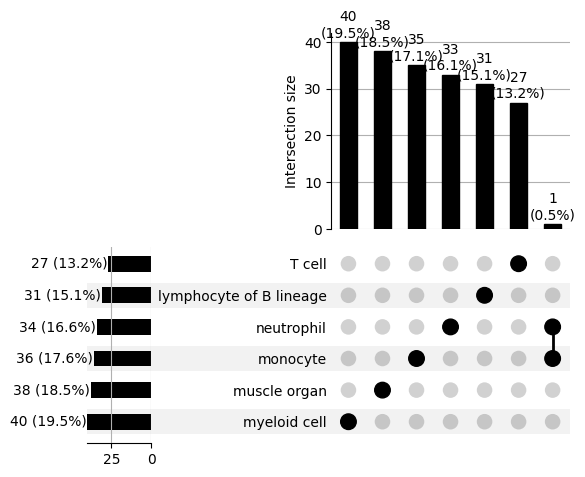

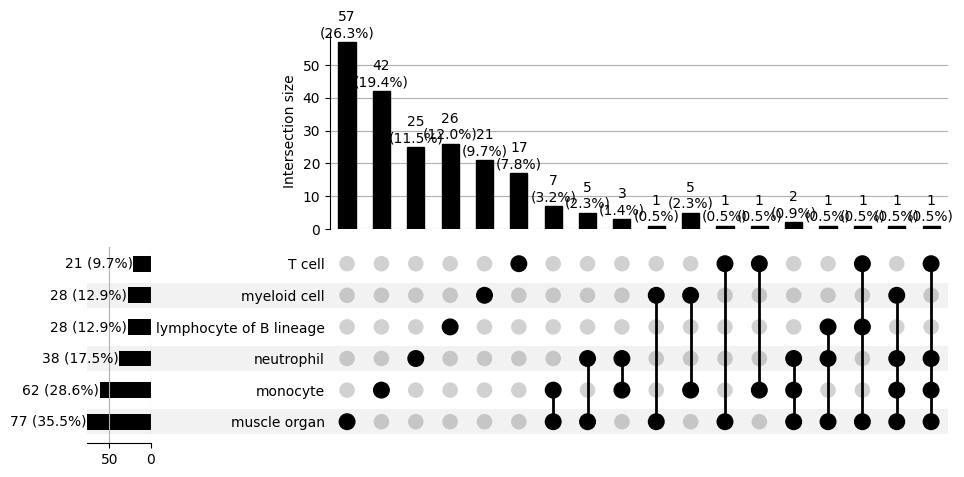

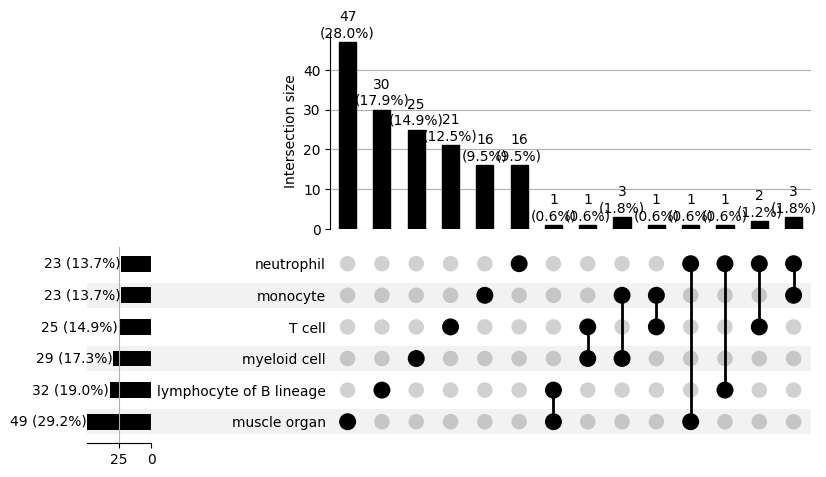

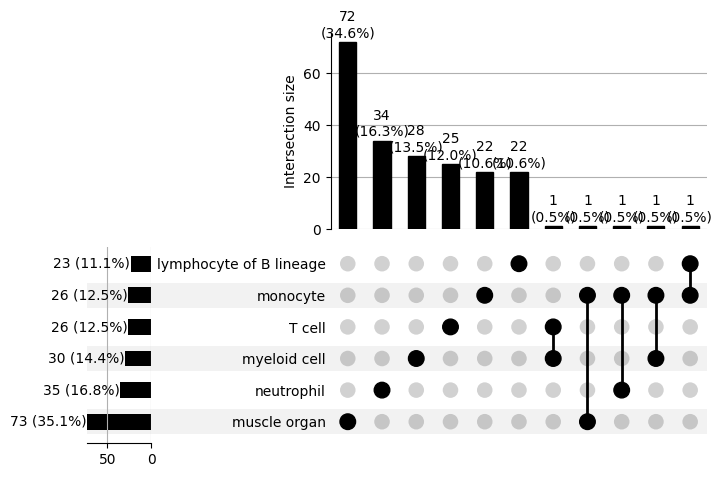

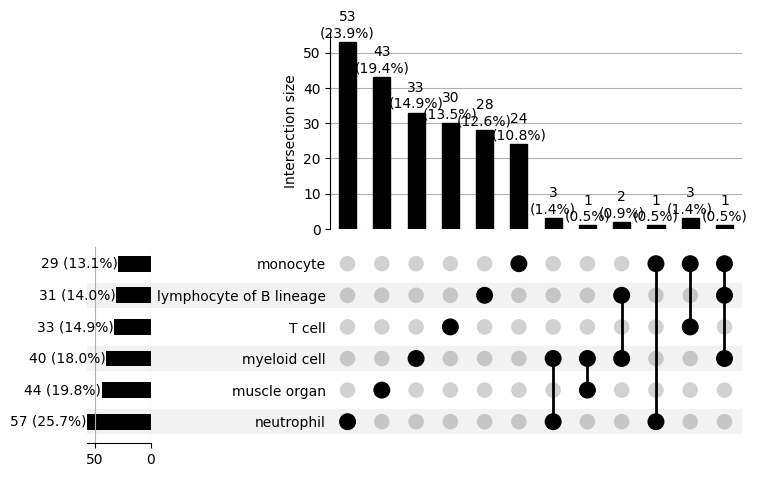

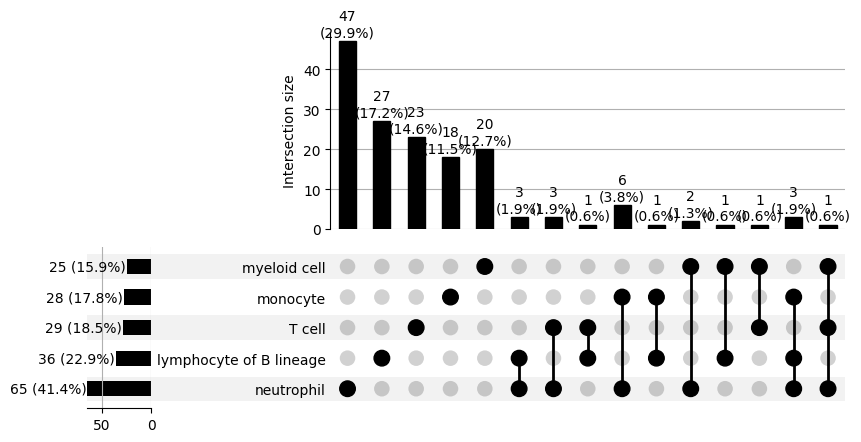

In [94]:
# sample ontology

# for histone in ["h3k27ac", "h3k27me3", "h3k36me3", "h3k4me1", "h3k4me3", "h3k9me3"]:
#     meta = copy.deepcopy(my_meta)
#     meta.select_category_subsets("assay_epiclass", [histone])

#     run_logdir = logdir / histone
#     run_logdir.mkdir(parents=False, exist_ok=True)

#     important_features = run_the_whole_thing(
#         metadata=meta,
#         shap_dir=logdir,
#         output_dir=run_logdir,
#         label_category=CELL_TYPE,
#         top_n=100,
#     )

#     feat_90 = {name:sets[90] for name, sets in important_features.items()}
#     upset_features = upsetplot.from_contents(feat_90)

#     fig = upsetplot.UpSet(upset_features, subset_size='count', show_counts=True, show_percentages=True).plot()
#     pyplot.savefig(run_logdir / f"upset_{histone}.png", dpi=300)

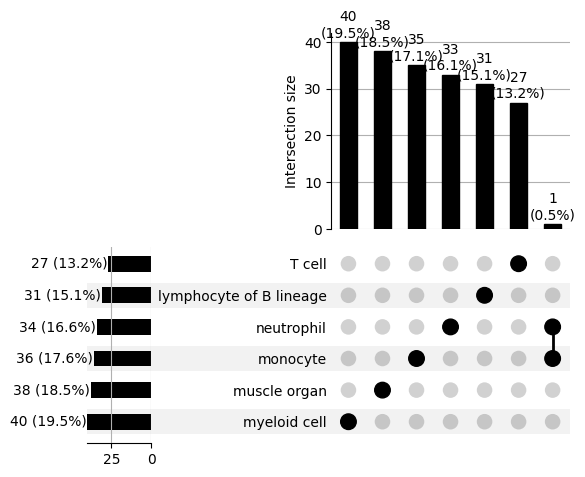

In [54]:
# important_features = run_the_whole_thing(
#     metadata=my_meta,
#     shap_logdir=logdir,
#     label_category=SEX,
#     top_n=100,
# )

In [ ]:
feat_intersection = set.intersection(
    *[set(feat_list[90]) for feat_list in important_features.values()]
)

male_feat = set(important_features["male"][90])
female_feat = set(important_features["female"][90])

only_male = male_feat - female_feat
only_female = female_feat - male_feat

for feat_set, name in zip([only_female, only_male], ["only_female", "only_male"]):
    bed_vals = bins_to_bed_ranges(sorted(feat_set), chroms, resolution=RESOLUTION)
    var_name = f"{feat_set=}".split("=")[0]
    write_to_bed(
        bed_vals,
        logdir / f"frequent_features_{90}_{name}.bed",
        verbose=False,
    )

In [ ]:
run_alternative_analysis(
    metadata=my_meta,
    shap_logdir=logdir,
    label_category=SEX,
    selected_classes=["female", "male"],
    top_n=100,
)

In [ ]:
def rank_violin_plots(logdir: str | Path, selected_classes: list[str]) -> None:
    """Create violin plots of important feature ranks for selected classes."""
    logdir = Path(logdir)
    # Iterate through each class of interest
    for class_of_interest in selected_classes:
        # Initialize an empty figure
        fig = go.Figure()

        # Iterate through each class to add its violin plot to the figure
        for comparison_class in selected_classes:
            df = pd.read_csv(
                logdir
                / f"important_{class_of_interest}_features_in_{comparison_class}_shap_matrix.csv"
            )
            df = df.filter(
                like="Feature_"
            )  # Remove non-feature columns from DataFrame for plotting

            # Create violin plot for the current comparison_class
            violin = go.Violin(
                y=df.values.flatten(),  # Flattened feature ranks
                name=f"{comparison_class} (n={df.shape[0]})",  # Name of the violin plot
                box_visible=True,  # Display box inside the violin
                line_color=px.colors.qualitative.Plotly[
                    len(fig.data)
                ],  # Different color for each violin
                points="all",  # Display all points
            )
            fig.add_trace(violin)

            print(df.shape)
        # Set title and axis labels
        fig.update_layout(
            title=f"Violin plot of ranks for important features of '{class_of_interest}' ({df.shape[1]} features)",
            xaxis_title="Source Matrix",
            yaxis_title="Feature Rank",
        )

        # Show the figure
        fig.write_image(
            logdir / f"important_{class_of_interest}_feature_ranks_violin_plot.png"
        )
        fig.write_html(
            logdir / f"important_{class_of_interest}_feature_ranks_violin_plot.html"
        )
        fig.show()

In [ ]:
logdir

In [ ]:
# rank_violin_plots(
#     logdir=logdir / "feature_rank_analysis", selected_classes=["female", "male"]
# )

## Samples ontology class pairs important features overlap

In [ ]:
feature_union = set()
feature_intersection = set(list(important_features.values())[0][90])
for label, features in important_features.items():
    features_90 = features[90]
    print(f"\n\nClass: {label}")
    print(f"Most frequent features in 90th quantile: {features_90}")
    feature_union.update(features_90)
    feature_intersection &= set(features_90)

print(f"\n\nUnion of all features: {len(feature_union)} features")
print(
    f"\n\nIntersection of all features: {len(feature_intersection)} features: {feature_intersection}"
)

In [ ]:
def compute_intersections(important_features: dict) -> pd.DataFrame:
    """Compute all possible intersections between pairs of sets and store them in a DataFrame.

    Args:
        important_features (dict): Dictionary where keys are class labels and values are sets of important features.

    Returns:
        pd.DataFrame: A DataFrame containing the intersections and their properties.
    """
    sets = {
        label: set(quantile_features[90])
        for label, quantile_features in important_features.items()
    }
    records = []

    for set1_info, set2_info in itertools.combinations(sets.items(), 2):
        label1, set1 = set1_info
        label2, set2 = set2_info
        intersection = set1.intersection(set2)

        record = {
            "Set1_Label": label1,
            "Set2_Label": label2,
            "Set1_Size": len(set1),
            "Set2_Size": len(set2),
            "Intersection": intersection,
            "Intersection_Size": len(intersection),
        }

        records.append(record)

    return pd.DataFrame(records)

In [ ]:
df = compute_intersections(important_features)
df.to_csv(logdir / "feature_intersections_q90.csv", index=False)

In [ ]:
counter = Counter()
for feature_set in df["Intersection"]:
    counter.update(feature_set)

for k, v in counter.most_common():
    print(f"{k} {v}")

In [ ]:
feature_selection = []
sort_order = np.argsort(feature_selection)

bed_vals = bins_to_bed_ranges(sorted(feature_selection), chroms, resolution=RESOLUTION)

write_to_bed(bed_ranges=bed_vals, bed_path=logdir / "frequent_features.bed", verbose=True)

In [ ]:
# chroms

In [ ]:
for val in np.array(bed_vals)[sort_order.argsort()]:
    print(val)